The travelling salesman problem (TSP) asks the following question: "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

* Individual: route 
* Gene: city (x,y)
* Population: list of routes
* Fitness: inverse of route length
* Parents: two routes that are used to create a new route
* Mating pool: list of parents for the next population
* Elitism: carrying the best routes into the next generation

Since TSP requires to include all locations exactly one time, we will use ordered crossover: we will randomly select a subset of the first parent and fill the remainder of the route with the genes from second parent in the same order as the one in which they appear, without duplicates.<br>
We will also use elitism to retain the best routes, fitness proportional selection and city reverse-swapping for mutation.

In [4]:
import numpy as np
import random, operator, matplotlib.pyplot as plt
import pandas as pd

In [5]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, other):
        return np.sqrt(((self.x - other.x) ** 2) + ((self.y - other.y) ** 2))
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [6]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0.0
        self.fitness= 0.0
    
    def route_distance(self):
        if self.distance == 0:
            path_length = 0
            for i in range(0, len(self.route)):
                from_city = self.route[i]
                to_city = None
                if i + 1 < len(self.route):
                    to_city = self.route[i + 1]
                else:
                    to_city = self.route[0]
                path_length += from_city.distance(to_city)
            self.distance = path_length
        return self.distance
    
    def route_fitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.route_distance())
        return self.fitness

In [7]:
def create_route(city_list):
    return random.sample(city_list, len(city_list))

In [8]:
def initial_population(pop_size, city_list):
    population = []
    for i in range(0, pop_size):
        population.append(create_route(city_list))
    return population

In [9]:
def rank_routes(population):
    fitness_results = {}
    for i in range(0,len(population)):
        fitness_results[i] = Fitness(population[i]).route_fitness()
        
    return sorted(fitness_results.items(), key = operator.itemgetter(1), reverse = True)

Holding onto our best routes in fitness proportional selection

In [10]:
def selection(pop_ranked, elite_size):
    selection_results = []
    df = pd.DataFrame(np.array(pop_ranked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, elite_size):
        selection_results.append(pop_ranked[i][0])
    for i in range(0, len(pop_ranked) - elite_size):
        pick = 100*random.random()
        for i in range(0, len(pop_ranked)):
            if pick <= df.iat[i,3]:
                selection_results.append(pop_ranked[i][0])
                break
    return selection_results

In [20]:
def mating_pool(population, selection_results):
    matingpool = []
    for i in range(0, len(selection_results)):
        index = selection_results[i]
        matingpool.append(population[index])
    return matingpool

In [21]:
def breed(parent1, parent2):
    child = []
    child_1 = []
    child_2 = []
    gene_1 = int(random.random() * len(parent1))
    gene_2 = int(random.random() * len(parent1))
    start_gene = min(gene_1, gene_2)
    end_gene = max(gene_1, gene_2)
    
    for i in range(start_gene, end_gene):
        child_1.append(parent1[i]) 
        
    child = [item for item in parent2 if item not in child_1]
    for gene in child_1[::-1]:
        child.insert(start_gene, gene)
    return child

In [22]:
def breed_population(matingpool, elite_size):
    children = []
    length = len(matingpool) - elite_size
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,elite_size):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [23]:
def mutate(individual, p):
    if random.random() > p:
        return individual
    indexes=[]
    while len(indexes) < 1:
        indexes = np.random.choice(len(individual) + 1, 2, replace=False)
    tmp = individual[min(indexes): max(indexes)]
    tmp = tmp[::-1]
    individual[min(indexes): max(indexes)] = tmp
    return individual

In [24]:
def mutate_population(population, p):
    mutated_pop = []

    for ind in range(0, len(population)):
        mutated_ind = mutate(population[ind], p)
        mutated_pop.append(mutated_ind)
    return mutated_pop

In [25]:
def next_generation(current_gen, elite_size, p):
    pop_ranked = rank_routes(current_gen)
    selection_results = selection(pop_ranked, elite_size)
    matingpool = mating_pool(current_gen, selection_results)
    children = breed_population(matingpool, elite_size)
    nextgeneration = mutate_population(children, p)
    return nextgeneration

## Running the algorithm

In [26]:
city_list = []

with open(r'data_131.txt', 'r') as f:
    for line in f:
        x=int(line.split()[1])
        y=int(line.split()[2])
        city_list.append(City(x, y))

# Training plot

In [27]:
def genetic_algorithm_plot(population, pop_size, elite_size, p, generations):
    pop = initial_population(pop_size, population)
    print("Initial distance: " + str(1 / rank_routes(pop)[0][1]))
    progress = []
    progress.append(1 / rank_routes(pop)[0][1])
    
    for i in range(0, generations):
        pop = next_generation(pop, elite_size, p)
        progress.append(1 / rank_routes(pop)[0][1])
        
    print("Final distance: " + str(1 / rank_routes(pop)[0][1]))
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()
    
    best_index = rank_routes(pop)[0][0]
    best_route = pop[best_index]
    return best_route

Initial distance: 4147.135452350517
Final distance: 1002.5552399656577


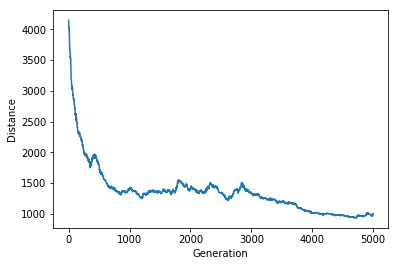

[(77,21),
 (84,20),
 (107,27),
 (79,37),
 (74,35),
 (34,15),
 (34,5),
 (25,11),
 (25,9),
 (25,23),
 (28,28),
 (25,26),
 (25,22),
 (18,11),
 (18,13),
 (15,19),
 (9,10),
 (12,10),
 (11,10),
 (15,13),
 (18,17),
 (28,16),
 (28,20),
 (34,29),
 (41,32),
 (41,34),
 (38,30),
 (35,31),
 (32,31),
 (34,31),
 (41,36),
 (41,35),
 (18,23),
 (15,25),
 (5,19),
 (5,13),
 (15,8),
 (10,10),
 (12,5),
 (8,0),
 (2,0),
 (0,13),
 (5,8),
 (5,25),
 (0,26),
 (0,27),
 (5,31),
 (15,43),
 (18,42),
 (18,41),
 (15,37),
 (18,33),
 (18,29),
 (18,39),
 (18,35),
 (18,31),
 (38,20),
 (41,23),
 (40,22),
 (48,27),
 (57,12),
 (57,25),
 (56,25),
 (61,45),
 (61,47),
 (57,44),
 (51,47),
 (51,45),
 (28,47),
 (18,45),
 (18,44),
 (28,40),
 (28,43),
 (34,41),
 (34,38),
 (38,34),
 (34,26),
 (33,26),
 (32,26),
 (33,29),
 (33,31),
 (28,34),
 (28,30),
 (25,28),
 (18,25),
 (18,27),
 (5,37),
 (0,39),
 (5,43),
 (18,37),
 (15,31),
 (18,19),
 (25,29),
 (25,24),
 (18,21),
 (18,15),
 (25,15),
 (33,15),
 (38,16),
 (35,17),
 (48,22),
 (64,22),


In [29]:
genetic_algorithm_plot(population=city_list, pop_size=40, elite_size=12, p=0.4, generations=5000)